## Few shot learning with Reptile

##### Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import urllib3

c:\Users\Interns\Desktop\fsl-tutorial\fsl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Define the hyperparameters

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 2000
eval_iters = 5
inner_iters = 4

eval_interval = 1
train_shots = 20
shots = 5
classes = 5

#### Prepare the data

In [3]:
class Dataset:
        # This class will facilitate the creation of a few-shot dataset
        # from the onniglot dataset that can be sampled from quickly while aslo
        # allowing to create new labels at the same time.
    
    def __init__(self, training):
        #Download the tfrecord files containing the omniglot data and covert to a dataset.
        split = 'train' if training else 'test'
        ds = tfds.load('omniglot', split=split, as_supervised=True, shuffle_files=False)
        
        def extraction(image, label):
            """
            This function will shrink the Omniglot images to the desired size,
            scale pixel values and convert the RGB image to grayscale
            """    
            image = tf.image.convert_image_dtype(image, tf.float32)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.resize(image, [28, 28])
            return image, label

        # Iterate over the dataset to get each individual image and its class,
        # and put that data into a dictionary.
        self.data = {}
                    
        for image, label in ds.map(extraction):
            image = image.numpy()
            label = str(label.numpy())
            if label not in self.data:
                self.data[label] = []
            self.data[label].append(image)
            self.labels = list(self.data.keys())
        
    def get_mini_dataset(self, batch_size, repetitions, shots, num_classes, split=False):
        temp_labels = np.zeros(shape=(num_classes * shots))
        temp_images = np.zeros(shape=(num_classes * shots, 28, 28, 1))
        if split:
            test_labels = np.zeros(shape=(num_classes))
            test_images = np.zeros(shape=(num_classes, 28, 28, 1))
            
        
        label_subset = random.choices(self.labels, k=num_classes)
        for class_idx, class_obj in enumerate(label_subset):
            # Use enumarated index as a temporary label for mini-batch in few shot learning.
            temp_labels[class_idx*shots : (class_idx + 1) * shots] = class_idx
            # If creating a split dataset for testing, select an extra sample from each label
            # to create the test dataset.
            if split:
                test_labels[class_idx] = class_idx
                images_to_split = random.choices(self.data[label_subset[class_idx]], k=shots+1)
                test_images[class_idx] = images_to_split[-1]
                temp_images[class_idx * shots : (class_idx + 1) * shots] = images_to_split[:-1]
            else:
                # For each index in the randomly selected label_subset, sample 
                # the necessary number of images.
                temp_images[class_idx * shots : (class_idx + 1) * shots] = random.choices(self.data[label_subset[class_idx]], k=shots)
            
            dataset = tf.data.Dataset.from_tensor_slices((temp_images.astype(np.float32), temp_labels.astype(np.int32)))
            
            if split:
                return dataset, test_images, test_labels
            
            return dataset 

In [4]:
urllib3.disable_warnings()
train_dataset = Dataset(training = True)
test_dataset = Dataset(training=False)


### Visualize some examples from the dataset

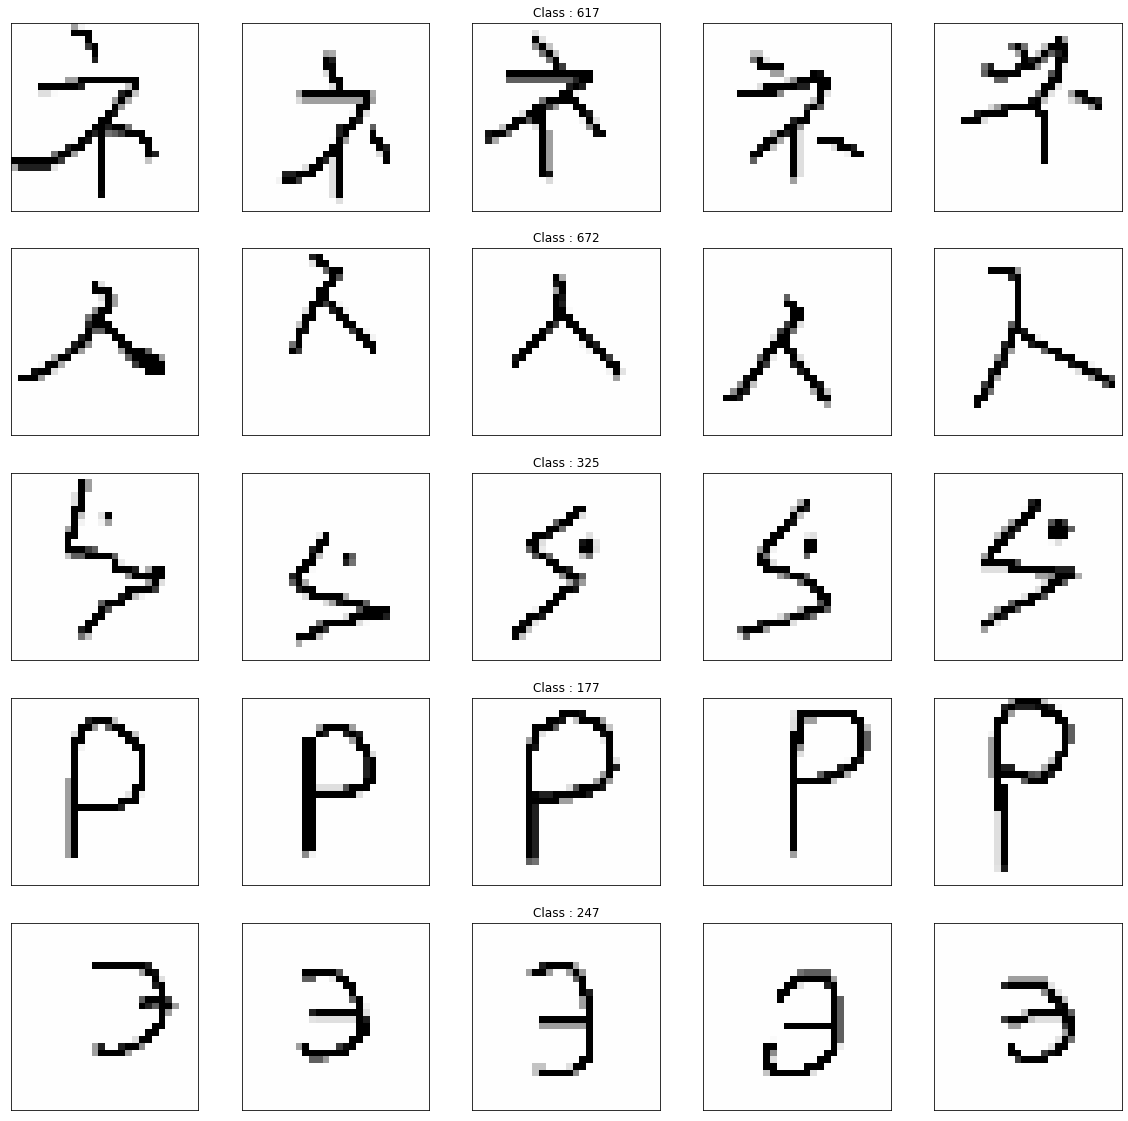

In [5]:
def visualize_subset(data, n_show_images=5):
    """
    Visualizes the omniglot dataset.

    Args:
        data (_type_): Omniglot test or training dataset
        n_show_images (int, optional): _description_. Defaults to 5.
    """
    _, axarr = plt.subplots(nrows=n_show_images, ncols=n_show_images, figsize=(20, 20))

    sample_keys = list(data.data.keys())

    for a in range(n_show_images):
        for b in range(n_show_images):
            temp_image = data.data[sample_keys[a]][b]
            temp_image = np.stack((temp_image[:, :, 0],) * 3, axis=2)
            temp_image *= 255
            temp_image = np.clip(temp_image, 0, 255).astype("uint8")
            if b == 2:
                axarr[a, b].set_title("Class : " + sample_keys[a])
            axarr[a, b].imshow(temp_image, cmap="gray")
            axarr[a, b].xaxis.set_visible(False)
            axarr[a, b].yaxis.set_visible(False)
    plt.show()

visualize_subset(data=train_dataset)

### Build the model

In [6]:
def conv_bn(x):
    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

In [7]:
inputs = layers.Input(shape=(28, 28, 1))
x = conv_bn(inputs)
x = conv_bn(x)
x = conv_bn(x)
x = conv_bn(x)
x = layers.Flatten()(x)
outputs = layers.Dense(classes, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile()
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

### Train the model

In [9]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = train_dataset.get_mini_dataset(
        inner_batch_size, inner_iters, train_shots, classes
    )
    for images, labels in mini_dataset:
        with tf.GradientTape() as tape:
            preds = model(images)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights()
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
        for dataset in (train_dataset, test_dataset):
            # Sample a mini dataset from the full dataset.
            train_set, test_images, test_labels = dataset.get_mini_dataset(
                eval_batch_size, eval_iters, shots, classes, split=True
            )
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for images, labels in train_set:
                with tf.GradientTape() as tape:
                    preds = model(images)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(test_images)
            test_preds = tf.argmax(test_preds).numpy()
            num_correct = (test_preds == test_labels).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

ValueError: Exception encountered when calling layer "model" (type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 256, but received input with shape (28, 128)

Call arguments received:
  • inputs=tf.Tensor(shape=(28, 28, 1), dtype=float32)
  • training=False
  • mask=None